In [1]:
import numpy as np
import pandas as pd
import torch
import torchvision
from torchvision.utils import make_grid
# import torchvision.utils as vutils
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import math
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR

In [2]:
df = pd.read_csv("train.csv")

In [3]:
len(df)

42000

In [4]:
# Find the maximum number of occurrences of any digit
max_size = df['label'].value_counts().max()

# Use pd.concat to create a list of dataframes to be concatenated
frames = [df]  # Start with the original dataframe

# Loop through each class group and append necessary duplicates
for class_index, group in df.groupby('label'):
    samples_to_add = max_size - len(group)
    if samples_to_add > 0:
        frames.append(group.sample(samples_to_add, replace=True))

# Concatenate all the frames together and shuffle the dataframe
df = pd.concat(frames).sample(frac=1).reset_index(drop=True)

# Check the new value counts to confirm balancing
print(df['label'].value_counts())

label
3    4684
1    4684
5    4684
4    4684
0    4684
9    4684
7    4684
8    4684
2    4684
6    4684
Name: count, dtype: int64


In [5]:
# 1 represents real, 0 fake
df['label'] = 1

In [6]:
X_discriminator = df.drop('label', axis=1)
y_discriminator = torch.tensor(df['label'].values, dtype=torch.float32)

In [7]:
pixel_columns = df.shape[1] - 1  # subtracting 1 for the label column

image_side_length = int(pixel_columns**0.5)
print(f"Each image is {image_side_length}x{image_side_length} pixels.")

Each image is 28x28 pixels.


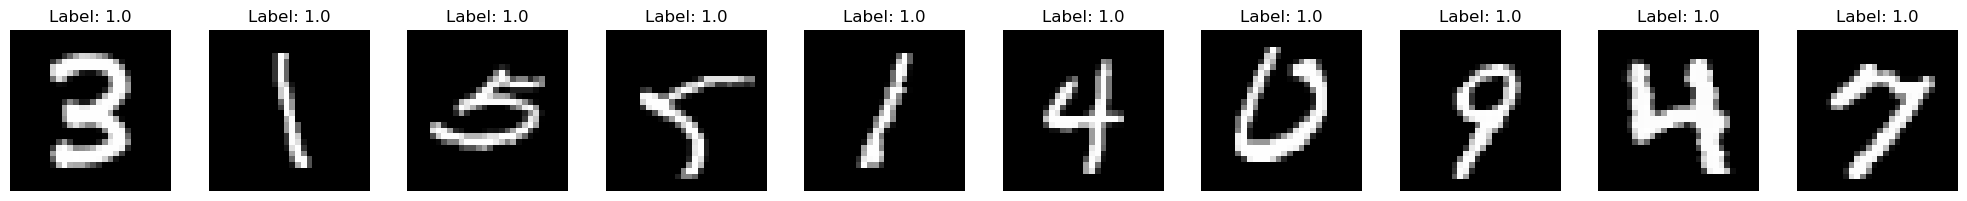

In [8]:
fig, axes = plt.subplots(1, 10, figsize=(20, 2))  
for i, ax in enumerate(axes):
    # Reshape each row into 28x28 array and plot
    img = X_discriminator.iloc[i].to_numpy().reshape(28, 28)
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Label: {y_discriminator[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [9]:
X_discriminator = X_discriminator.values.reshape(-1, 1, 28, 28)
X_discriminator = torch.tensor(X_discriminator).float() / 255.0

In [10]:
dataset_discriminator = TensorDataset(X_discriminator, y_discriminator)
loader_discriminator = DataLoader(dataset_discriminator, batch_size=32, shuffle=True)

In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        self.conv6 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(in_features=128*7*7, out_features=1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(F.relu(self.conv5(x)))

        x = F.relu(self.conv6(x))
        x = x.view(-1, 128*7*7)
        x = self.dropout(x)
        x = self.fc(x)
        return torch.sigmoid(x)

In [12]:
class Generator(nn.Module):
    def __init__(self, noise_dim):
        super(Generator, self).__init__()
        self.fc = nn.Linear(in_features=noise_dim, out_features=noise_dim) # (1, 49) -> (1, 7, 7)
        self.convT1 = nn.ConvTranspose2d(in_channels=1, out_channels=128, kernel_size=4, stride=1)  # (1, 7, 7) -> (1, 10, 10)
        self.bn1 = nn.BatchNorm2d(num_features=128)
        self.convT2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2) # (1, 10, 10) -> (1, 22, 22)
        self.bn2 = nn.BatchNorm2d(num_features=64)
        self.convT3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=1) # (1, 22, 22) -> (1, 24, 24)
        self.bn3 = nn.BatchNorm2d(num_features=32)
        self.convT4 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=1) # (1, 24, 24) -> (1, 26, 26)
        self.bn4 = nn.BatchNorm2d(num_features=16)
        # self.dropout = nn.Dropout(0.3)
        self.convT5 = nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=1) # (1, 26, 26) -> (1, 28, 28)

    def forward(self, x):
        x = F.leaky_relu(self.fc(x))
        x = x.view(-1, 1, int(math.sqrt(noise_dim)), int(math.sqrt(noise_dim)))
        x = F.relu(self.bn1(self.convT1(x)))
        x = F.relu(self.bn2(self.convT2(x)))
        x = F.relu(self.bn3(self.convT3(x)))
        x = F.relu(self.bn4(self.convT4(x)))
        # x = self.dropout(x)
        x = F.sigmoid(self.convT5(x))
        return x

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

noise_dim = 49
generator = Generator(noise_dim=noise_dim).to(device)
discriminator = Discriminator().to(device)

optim_G = torch.optim.Adam(generator.parameters(), lr=0.0001024, betas=(0.5, 0.999))
optim_D = torch.optim.Adam(discriminator.parameters(), lr=0.0001024, betas=(0.5, 0.999))
scheduler_G = StepLR(optimizer=optim_G, step_size=20, gamma=0.8)
scheduler_D = StepLR(optimizer=optim_D, step_size=20, gamma=0.8)

100%|███████████████████████████████████████████████████| 1464/1464 [00:26<00:00, 54.71it/s, loss_D=1.25, loss_G=0.696]


Epoch [1/150] - LR G: 0.0001024, LR D: 0.0001024
Epoch [1/150] - Average D loss: 0.9236, Average G loss: 1.4818


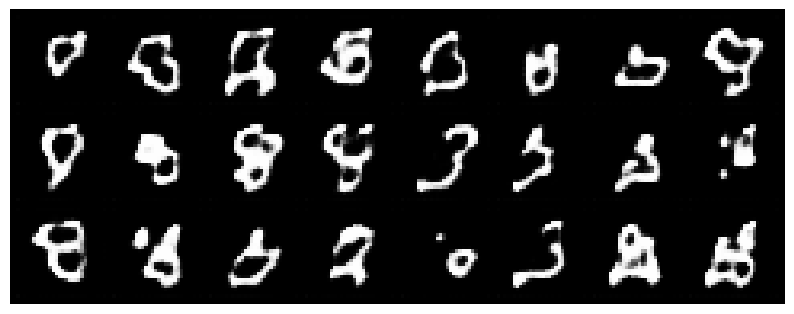

100%|███████████████████████████████████████████████████| 1464/1464 [00:26<00:00, 55.24it/s, loss_D=1.07, loss_G=0.954]


Epoch [2/150] - LR G: 0.0001024, LR D: 0.0001024
Epoch [2/150] - Average D loss: 1.2556, Average G loss: 0.8553


100%|███████████████████████████████████████████████████| 1464/1464 [00:58<00:00, 25.23it/s, loss_D=1.28, loss_G=0.936]


Epoch [3/150] - LR G: 0.0001024, LR D: 0.0001024
Epoch [3/150] - Average D loss: 1.2064, Average G loss: 0.9369


100%|███████████████████████████████████████████████████| 1464/1464 [01:01<00:00, 23.81it/s, loss_D=1.07, loss_G=0.778]


Epoch [4/150] - LR G: 0.0001024, LR D: 0.0001024
Epoch [4/150] - Average D loss: 1.1763, Average G loss: 0.9668


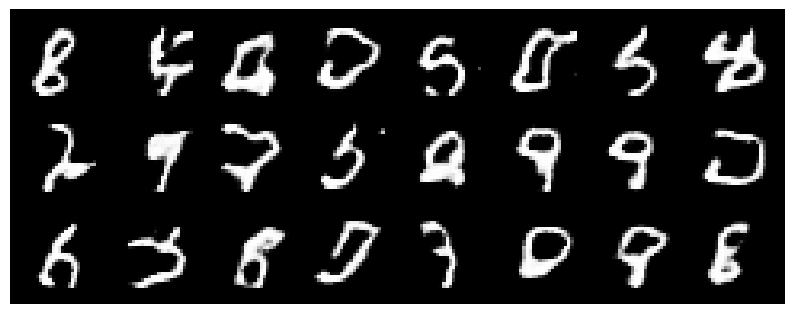

100%|███████████████████████████████████████████████████| 1464/1464 [01:01<00:00, 23.80it/s, loss_D=1.17, loss_G=0.749]


Epoch [5/150] - LR G: 0.0001024, LR D: 0.0001024
Epoch [5/150] - Average D loss: 1.2105, Average G loss: 0.9095


100%|████████████████████████████████████████████████████| 1464/1464 [01:01<00:00, 23.84it/s, loss_D=1.12, loss_G=1.14]


Epoch [6/150] - LR G: 0.0001024, LR D: 0.0001024
Epoch [6/150] - Average D loss: 1.1495, Average G loss: 0.9799


100%|████████████████████████████████████████████████████| 1464/1464 [01:01<00:00, 23.71it/s, loss_D=1.09, loss_G=1.31]


Epoch [7/150] - LR G: 0.0001024, LR D: 0.0001024
Epoch [7/150] - Average D loss: 1.0640, Average G loss: 1.1003


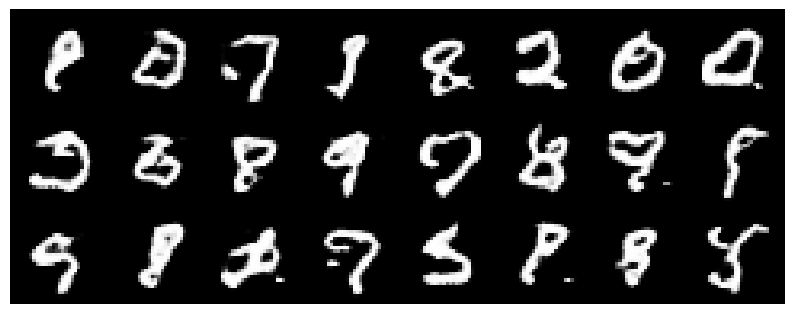

100%|████████████████████████████████████████████████████| 1464/1464 [01:01<00:00, 23.78it/s, loss_D=0.892, loss_G=1.1]


Epoch [8/150] - LR G: 0.0001024, LR D: 0.0001024
Epoch [8/150] - Average D loss: 0.9870, Average G loss: 1.2356


100%|█████████████████████████████████████████████████████| 1464/1464 [01:01<00:00, 23.73it/s, loss_D=1.18, loss_G=1.2]


Epoch [9/150] - LR G: 0.0001024, LR D: 0.0001024
Epoch [9/150] - Average D loss: 0.9440, Average G loss: 1.3396


100%|████████████████████████████████████████████████████| 1464/1464 [01:01<00:00, 23.77it/s, loss_D=1.11, loss_G=1.55]


Epoch [10/150] - LR G: 0.0001024, LR D: 0.0001024
Epoch [10/150] - Average D loss: 0.9205, Average G loss: 1.4008


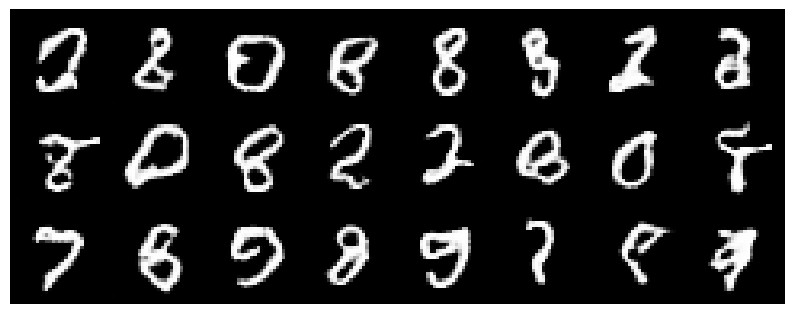

100%|███████████████████████████████████████████████████| 1464/1464 [01:01<00:00, 23.70it/s, loss_D=0.872, loss_G=1.42]


Epoch [11/150] - LR G: 0.0001024, LR D: 0.0001024
Epoch [11/150] - Average D loss: 0.8958, Average G loss: 1.4580


100%|███████████████████████████████████████████████████| 1464/1464 [01:01<00:00, 23.65it/s, loss_D=0.684, loss_G=1.83]


Epoch [12/150] - LR G: 0.0001024, LR D: 0.0001024
Epoch [12/150] - Average D loss: 0.8747, Average G loss: 1.5033


100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.54it/s, loss_D=0.762, loss_G=1.48]


Epoch [13/150] - LR G: 0.0001024, LR D: 0.0001024
Epoch [13/150] - Average D loss: 0.8556, Average G loss: 1.5504


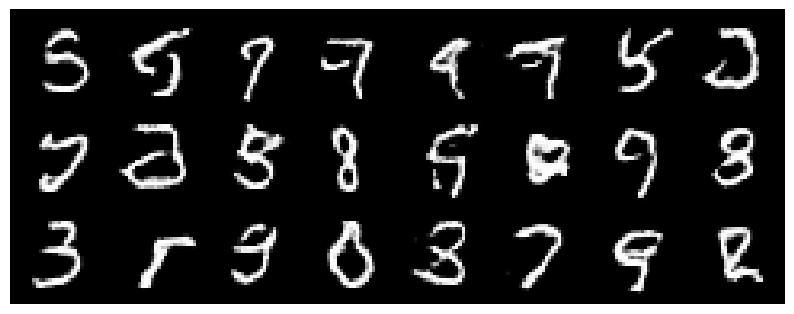

100%|████████████████████████████████████████████████████| 1464/1464 [01:04<00:00, 22.69it/s, loss_D=1.08, loss_G=1.47]


Epoch [14/150] - LR G: 0.0001024, LR D: 0.0001024
Epoch [14/150] - Average D loss: 0.8315, Average G loss: 1.6054


100%|███████████████████████████████████████████████████| 1464/1464 [01:03<00:00, 23.03it/s, loss_D=0.781, loss_G=1.28]


Epoch [15/150] - LR G: 0.0001024, LR D: 0.0001024
Epoch [15/150] - Average D loss: 0.8155, Average G loss: 1.6469


100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.26it/s, loss_D=0.995, loss_G=1.29]

Epoch [16/150] - LR G: 0.0001024, LR D: 0.0001024
Epoch [16/150] - Average D loss: 0.8111, Average G loss: 1.6671


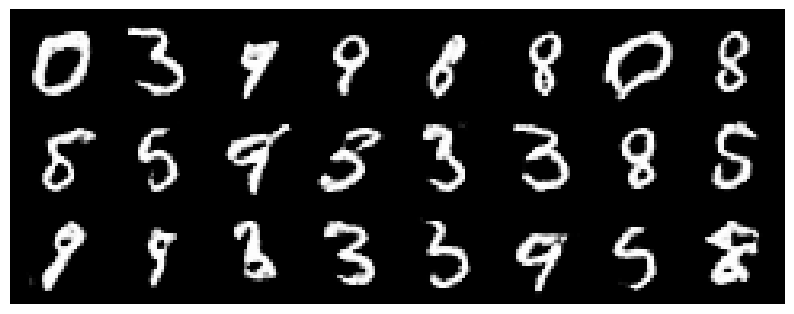

100%|███████████████████████████████████████████████████| 1464/1464 [01:01<00:00, 23.66it/s, loss_D=0.835, loss_G=1.38]


Epoch [17/150] - LR G: 0.0001024, LR D: 0.0001024
Epoch [17/150] - Average D loss: 0.8098, Average G loss: 1.6718


100%|███████████████████████████████████████████████████| 1464/1464 [01:01<00:00, 23.70it/s, loss_D=0.596, loss_G=1.82]


Epoch [18/150] - LR G: 0.0001024, LR D: 0.0001024
Epoch [18/150] - Average D loss: 0.8029, Average G loss: 1.6964


100%|████████████████████████████████████████████████████| 1464/1464 [01:01<00:00, 23.69it/s, loss_D=0.754, loss_G=1.7]


Epoch [19/150] - LR G: 0.0001024, LR D: 0.0001024
Epoch [19/150] - Average D loss: 0.7995, Average G loss: 1.6897


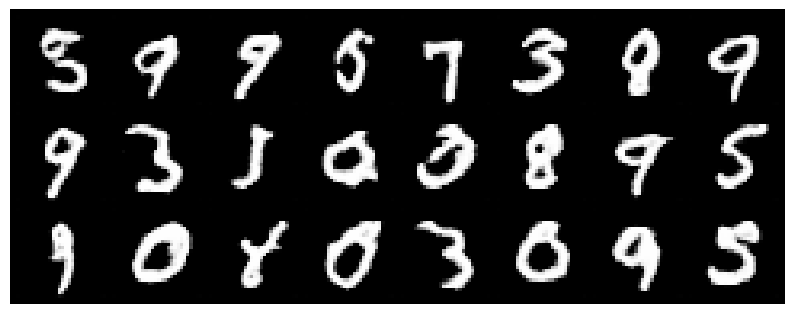

100%|███████████████████████████████████████████████████| 1464/1464 [01:01<00:00, 23.65it/s, loss_D=0.519, loss_G=2.01]


Epoch [20/150] - LR G: 0.0000819, LR D: 0.0000819
Epoch [20/150] - Average D loss: 0.7871, Average G loss: 1.7130


100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.61it/s, loss_D=0.737, loss_G=1.57]


Epoch [21/150] - LR G: 0.0000819, LR D: 0.0000819
Epoch [21/150] - Average D loss: 0.7731, Average G loss: 1.7297


100%|███████████████████████████████████████████████████| 1464/1464 [01:01<00:00, 23.63it/s, loss_D=0.892, loss_G=1.97]


Epoch [22/150] - LR G: 0.0000819, LR D: 0.0000819
Epoch [22/150] - Average D loss: 0.7667, Average G loss: 1.7406


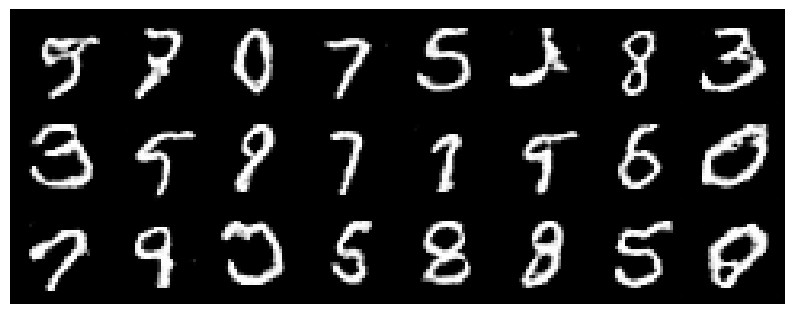

100%|████████████████████████████████████████████████████| 1464/1464 [01:01<00:00, 23.67it/s, loss_D=0.87, loss_G=1.29]


Epoch [23/150] - LR G: 0.0000819, LR D: 0.0000819
Epoch [23/150] - Average D loss: 0.7691, Average G loss: 1.7359


100%|███████████████████████████████████████████████████| 1464/1464 [01:01<00:00, 23.63it/s, loss_D=0.831, loss_G=1.49]


Epoch [24/150] - LR G: 0.0000819, LR D: 0.0000819
Epoch [24/150] - Average D loss: 0.7677, Average G loss: 1.7527


100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.57it/s, loss_D=0.817, loss_G=1.93]


Epoch [25/150] - LR G: 0.0000819, LR D: 0.0000819
Epoch [25/150] - Average D loss: 0.7661, Average G loss: 1.7581


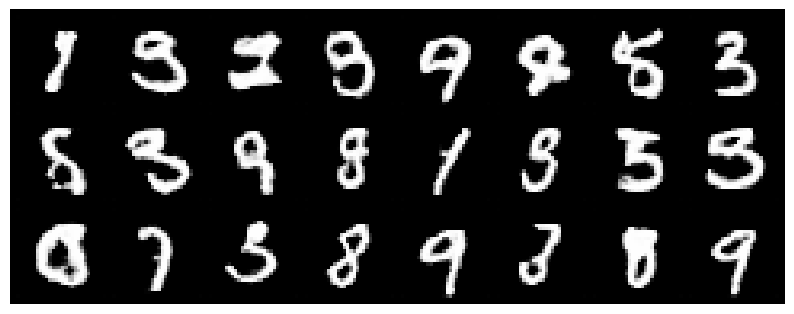

100%|████████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.54it/s, loss_D=0.75, loss_G=1.84]


Epoch [26/150] - LR G: 0.0000819, LR D: 0.0000819
Epoch [26/150] - Average D loss: 0.7659, Average G loss: 1.7444


100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.52it/s, loss_D=0.597, loss_G=1.78]


Epoch [27/150] - LR G: 0.0000819, LR D: 0.0000819
Epoch [27/150] - Average D loss: 0.7760, Average G loss: 1.7282


100%|████████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.57it/s, loss_D=1.02, loss_G=1.34]


Epoch [28/150] - LR G: 0.0000819, LR D: 0.0000819
Epoch [28/150] - Average D loss: 0.7646, Average G loss: 1.7602


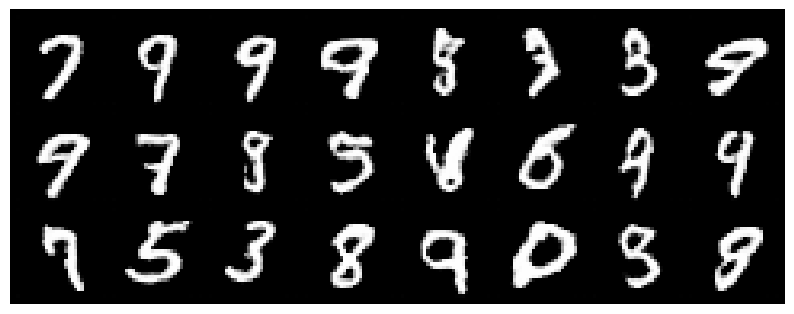

100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.55it/s, loss_D=0.697, loss_G=1.61]


Epoch [29/150] - LR G: 0.0000819, LR D: 0.0000819
Epoch [29/150] - Average D loss: 0.7653, Average G loss: 1.7475


100%|████████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.42it/s, loss_D=0.79, loss_G=2.04]


Epoch [30/150] - LR G: 0.0000819, LR D: 0.0000819
Epoch [30/150] - Average D loss: 0.7648, Average G loss: 1.7465


100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.51it/s, loss_D=0.946, loss_G=1.86]


Epoch [31/150] - LR G: 0.0000819, LR D: 0.0000819
Epoch [31/150] - Average D loss: 0.7677, Average G loss: 1.7386


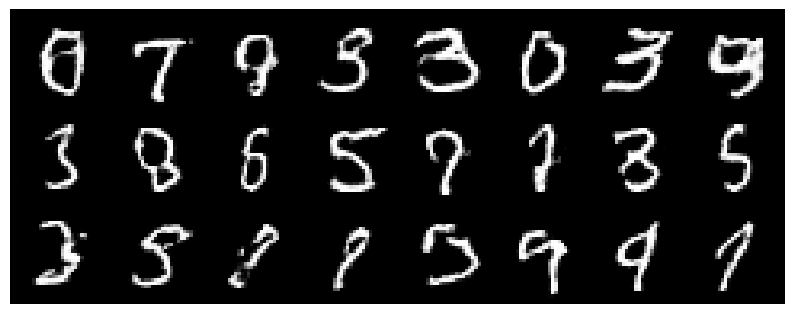

100%|████████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.48it/s, loss_D=1.14, loss_G=1.67]


Epoch [32/150] - LR G: 0.0000819, LR D: 0.0000819
Epoch [32/150] - Average D loss: 0.7606, Average G loss: 1.7446


100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.56it/s, loss_D=0.868, loss_G=1.18]


Epoch [33/150] - LR G: 0.0000819, LR D: 0.0000819
Epoch [33/150] - Average D loss: 0.7696, Average G loss: 1.7306


100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.55it/s, loss_D=0.706, loss_G=1.99]


Epoch [34/150] - LR G: 0.0000819, LR D: 0.0000819
Epoch [34/150] - Average D loss: 0.7587, Average G loss: 1.7527


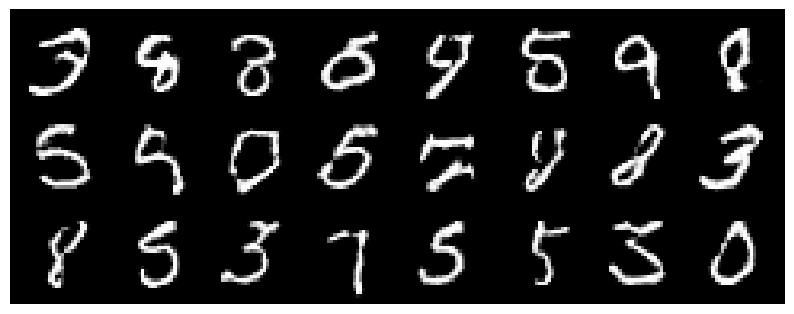

100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.48it/s, loss_D=0.802, loss_G=1.69]


Epoch [35/150] - LR G: 0.0000819, LR D: 0.0000819
Epoch [35/150] - Average D loss: 0.7672, Average G loss: 1.7480


100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.43it/s, loss_D=0.676, loss_G=1.67]


Epoch [36/150] - LR G: 0.0000819, LR D: 0.0000819
Epoch [36/150] - Average D loss: 0.7342, Average G loss: 1.8044


100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.42it/s, loss_D=0.584, loss_G=2.07]


Epoch [37/150] - LR G: 0.0000819, LR D: 0.0000819
Epoch [37/150] - Average D loss: 0.7669, Average G loss: 1.7322


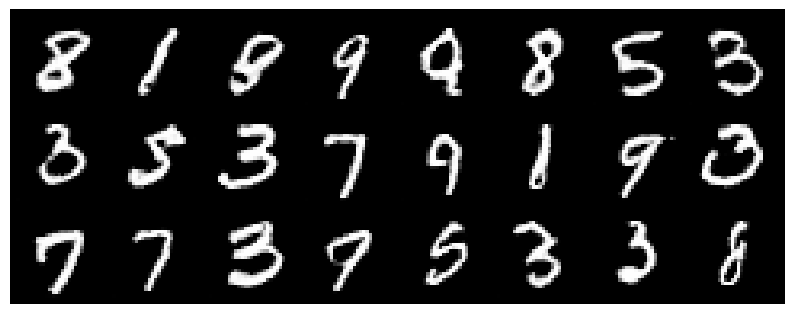

100%|█████████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.60it/s, loss_D=0.76, loss_G=1.6]


Epoch [38/150] - LR G: 0.0000819, LR D: 0.0000819
Epoch [38/150] - Average D loss: 0.7538, Average G loss: 1.7536


100%|████████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.49it/s, loss_D=1.02, loss_G=1.23]


Epoch [39/150] - LR G: 0.0000819, LR D: 0.0000819
Epoch [39/150] - Average D loss: 0.7659, Average G loss: 1.7354


100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.49it/s, loss_D=0.622, loss_G=1.55]


Epoch [40/150] - LR G: 0.0000655, LR D: 0.0000655
Epoch [40/150] - Average D loss: 0.7553, Average G loss: 1.7337


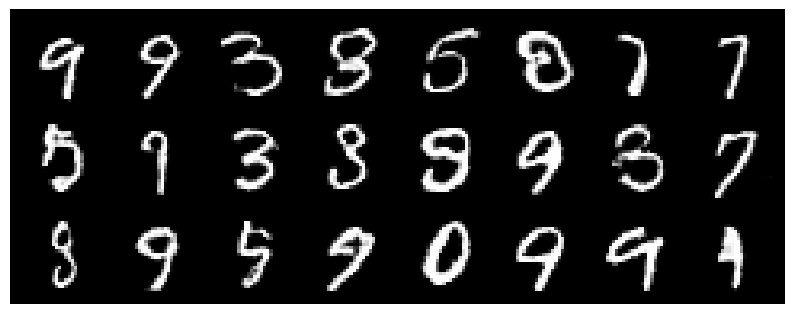

100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.39it/s, loss_D=0.799, loss_G=1.66]


Epoch [41/150] - LR G: 0.0000655, LR D: 0.0000655
Epoch [41/150] - Average D loss: 0.7469, Average G loss: 1.7390


100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.32it/s, loss_D=0.766, loss_G=1.87]


Epoch [42/150] - LR G: 0.0000655, LR D: 0.0000655
Epoch [42/150] - Average D loss: 0.7475, Average G loss: 1.7346


100%|███████████████████████████████████████████████████| 1464/1464 [01:04<00:00, 22.86it/s, loss_D=0.692, loss_G=1.58]


Epoch [43/150] - LR G: 0.0000655, LR D: 0.0000655
Epoch [43/150] - Average D loss: 0.7476, Average G loss: 1.7421


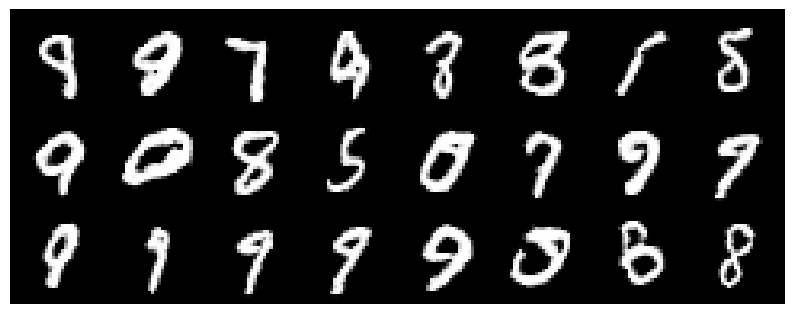

100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.44it/s, loss_D=0.602, loss_G=1.56]


Epoch [44/150] - LR G: 0.0000655, LR D: 0.0000655
Epoch [44/150] - Average D loss: 0.7479, Average G loss: 1.7420


100%|███████████████████████████████████████████████████| 1464/1464 [01:03<00:00, 23.23it/s, loss_D=0.608, loss_G=1.85]


Epoch [45/150] - LR G: 0.0000655, LR D: 0.0000655
Epoch [45/150] - Average D loss: 0.7455, Average G loss: 1.7416


100%|███████████████████████████████████████████████████| 1464/1464 [01:03<00:00, 23.05it/s, loss_D=0.685, loss_G=1.82]


Epoch [46/150] - LR G: 0.0000655, LR D: 0.0000655
Epoch [46/150] - Average D loss: 0.7479, Average G loss: 1.7392


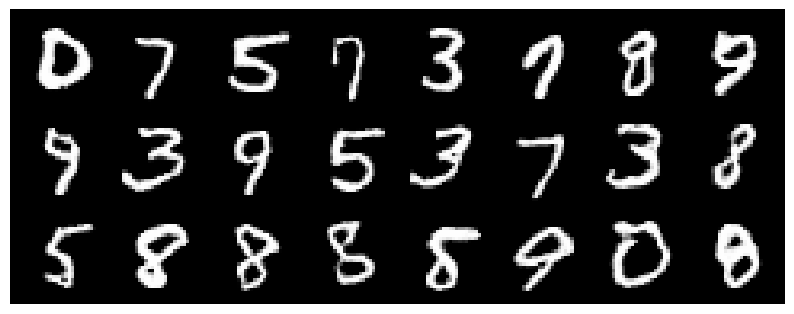

100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.47it/s, loss_D=0.685, loss_G=1.78]


Epoch [47/150] - LR G: 0.0000655, LR D: 0.0000655
Epoch [47/150] - Average D loss: 0.7442, Average G loss: 1.7504


100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.45it/s, loss_D=0.604, loss_G=1.82]


Epoch [48/150] - LR G: 0.0000655, LR D: 0.0000655
Epoch [48/150] - Average D loss: 0.7737, Average G loss: 1.7097


100%|███████████████████████████████████████████████████| 1464/1464 [01:01<00:00, 23.63it/s, loss_D=0.797, loss_G=1.82]


Epoch [49/150] - LR G: 0.0000655, LR D: 0.0000655
Epoch [49/150] - Average D loss: 0.7692, Average G loss: 1.6953


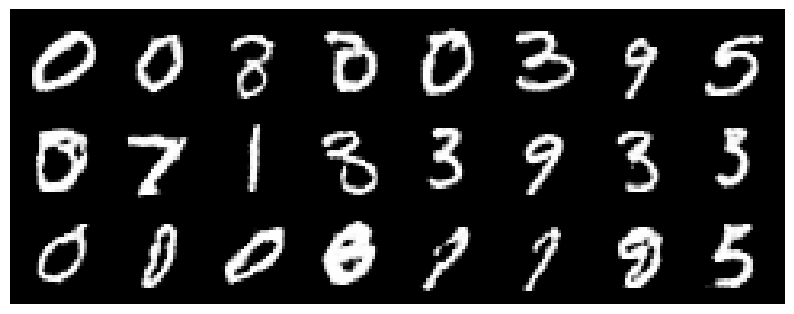

100%|████████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.56it/s, loss_D=0.896, loss_G=1.5]


Epoch [50/150] - LR G: 0.0000655, LR D: 0.0000655
Epoch [50/150] - Average D loss: 0.7541, Average G loss: 1.7365


100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.57it/s, loss_D=0.986, loss_G=1.65]


Epoch [51/150] - LR G: 0.0000655, LR D: 0.0000655
Epoch [51/150] - Average D loss: 0.7538, Average G loss: 1.7446


100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.51it/s, loss_D=0.847, loss_G=1.85]


Epoch [52/150] - LR G: 0.0000655, LR D: 0.0000655
Epoch [52/150] - Average D loss: 0.7523, Average G loss: 1.7445


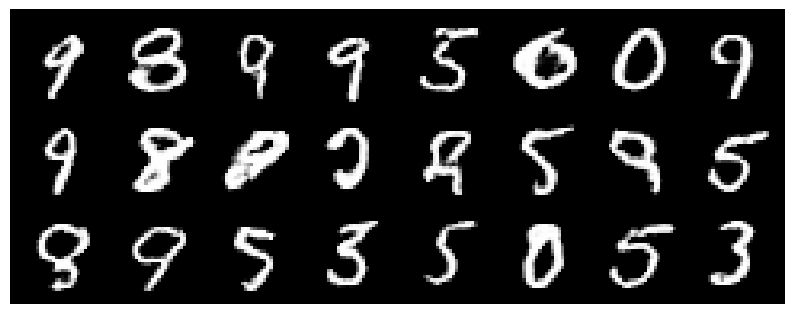

100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.60it/s, loss_D=0.639, loss_G=1.83]


Epoch [53/150] - LR G: 0.0000655, LR D: 0.0000655
Epoch [53/150] - Average D loss: 0.7403, Average G loss: 1.7686


100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.58it/s, loss_D=0.739, loss_G=1.61]


Epoch [54/150] - LR G: 0.0000655, LR D: 0.0000655
Epoch [54/150] - Average D loss: 0.7424, Average G loss: 1.7594


100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.49it/s, loss_D=0.642, loss_G=2.26]


Epoch [55/150] - LR G: 0.0000655, LR D: 0.0000655
Epoch [55/150] - Average D loss: 0.7350, Average G loss: 1.7741


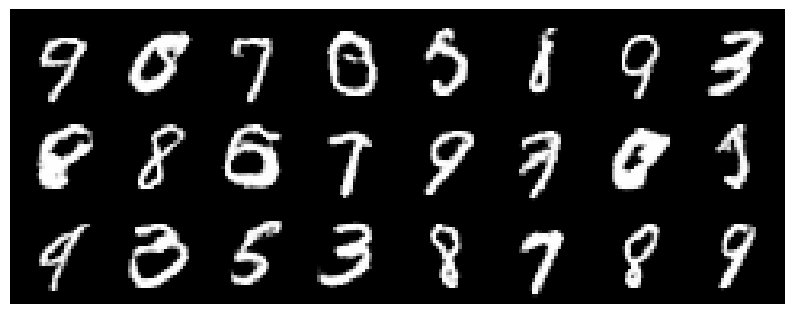

100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.52it/s, loss_D=0.848, loss_G=1.47]


Epoch [56/150] - LR G: 0.0000655, LR D: 0.0000655
Epoch [56/150] - Average D loss: 0.7359, Average G loss: 1.7748


100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.52it/s, loss_D=0.903, loss_G=1.79]


Epoch [57/150] - LR G: 0.0000655, LR D: 0.0000655
Epoch [57/150] - Average D loss: 0.7334, Average G loss: 1.7790


100%|████████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.45it/s, loss_D=0.629, loss_G=1.6]


Epoch [58/150] - LR G: 0.0000655, LR D: 0.0000655
Epoch [58/150] - Average D loss: 0.7305, Average G loss: 1.7662


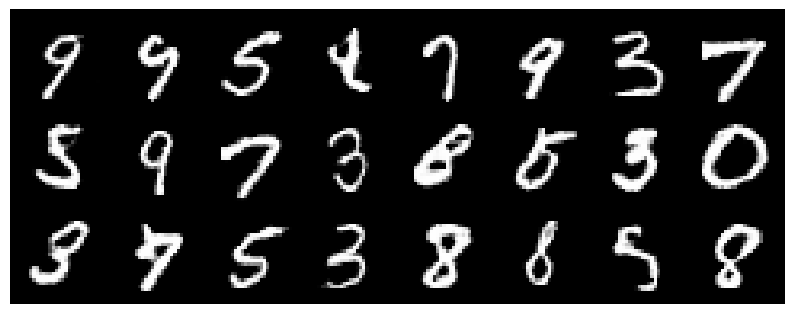

100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.42it/s, loss_D=0.761, loss_G=1.46]


Epoch [59/150] - LR G: 0.0000655, LR D: 0.0000655
Epoch [59/150] - Average D loss: 0.7280, Average G loss: 1.7885


100%|██████████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.53it/s, loss_D=0.664, loss_G=2]


Epoch [60/150] - LR G: 0.0000524, LR D: 0.0000524
Epoch [60/150] - Average D loss: 0.7348, Average G loss: 1.7748


100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.52it/s, loss_D=0.804, loss_G=1.83]


Epoch [61/150] - LR G: 0.0000524, LR D: 0.0000524
Epoch [61/150] - Average D loss: 0.7306, Average G loss: 1.7640


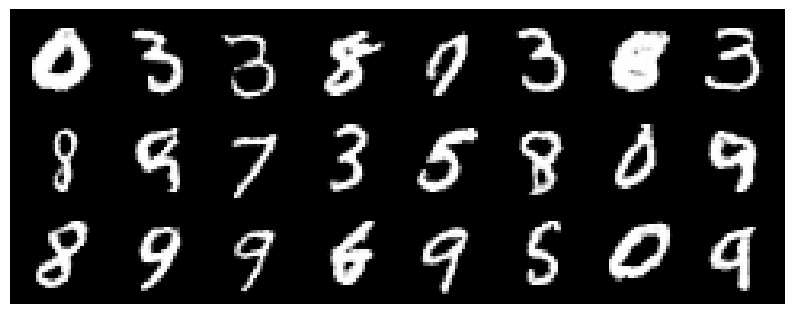

100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.42it/s, loss_D=0.818, loss_G=1.47]


Epoch [62/150] - LR G: 0.0000524, LR D: 0.0000524
Epoch [62/150] - Average D loss: 0.7264, Average G loss: 1.7704


100%|████████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.48it/s, loss_D=0.586, loss_G=1.8]


Epoch [63/150] - LR G: 0.0000524, LR D: 0.0000524
Epoch [63/150] - Average D loss: 0.7307, Average G loss: 1.7755


100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.50it/s, loss_D=0.724, loss_G=2.02]


Epoch [64/150] - LR G: 0.0000524, LR D: 0.0000524
Epoch [64/150] - Average D loss: 0.7212, Average G loss: 1.7863


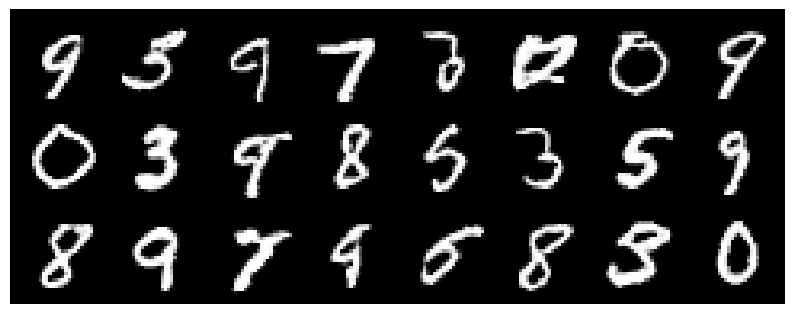

100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.53it/s, loss_D=0.786, loss_G=1.73]


Epoch [65/150] - LR G: 0.0000524, LR D: 0.0000524
Epoch [65/150] - Average D loss: 0.7248, Average G loss: 1.7792


100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.45it/s, loss_D=0.695, loss_G=1.98]


Epoch [66/150] - LR G: 0.0000524, LR D: 0.0000524
Epoch [66/150] - Average D loss: 0.7278, Average G loss: 1.7774


100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.52it/s, loss_D=0.651, loss_G=1.73]


Epoch [67/150] - LR G: 0.0000524, LR D: 0.0000524
Epoch [67/150] - Average D loss: 0.7259, Average G loss: 1.7884


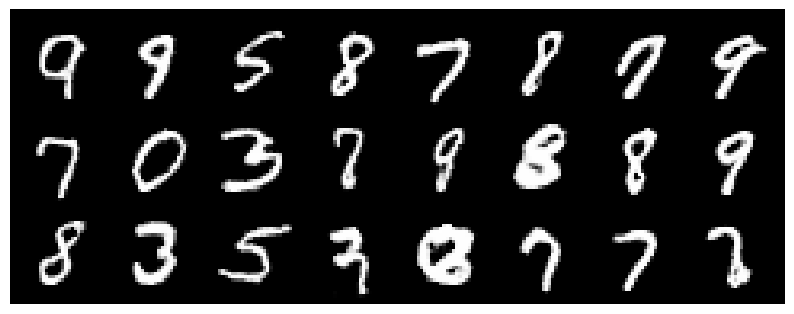

100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.42it/s, loss_D=0.508, loss_G=2.04]


Epoch [68/150] - LR G: 0.0000524, LR D: 0.0000524
Epoch [68/150] - Average D loss: 0.7227, Average G loss: 1.7906


100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.60it/s, loss_D=0.821, loss_G=1.77]


Epoch [69/150] - LR G: 0.0000524, LR D: 0.0000524
Epoch [69/150] - Average D loss: 0.7162, Average G loss: 1.8038


100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.55it/s, loss_D=0.859, loss_G=1.29]


Epoch [70/150] - LR G: 0.0000524, LR D: 0.0000524
Epoch [70/150] - Average D loss: 0.7222, Average G loss: 1.7929


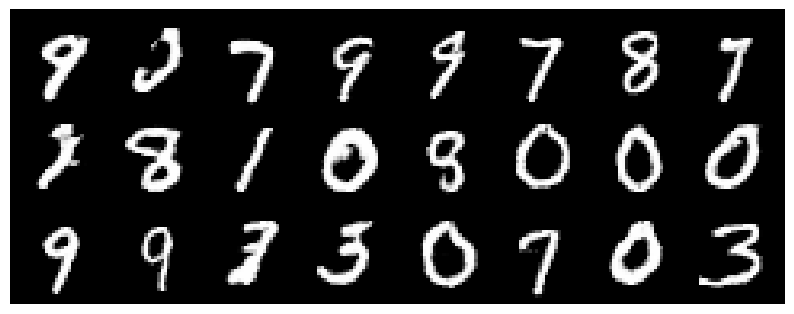

100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.38it/s, loss_D=0.827, loss_G=1.49]


Epoch [71/150] - LR G: 0.0000524, LR D: 0.0000524
Epoch [71/150] - Average D loss: 0.7163, Average G loss: 1.8071


100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.54it/s, loss_D=0.667, loss_G=1.99]


Epoch [72/150] - LR G: 0.0000524, LR D: 0.0000524
Epoch [72/150] - Average D loss: 0.7179, Average G loss: 1.8000


100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.50it/s, loss_D=0.766, loss_G=1.84]

Epoch [73/150] - LR G: 0.0000524, LR D: 0.0000524
Epoch [73/150] - Average D loss: 0.7168, Average G loss: 1.8104


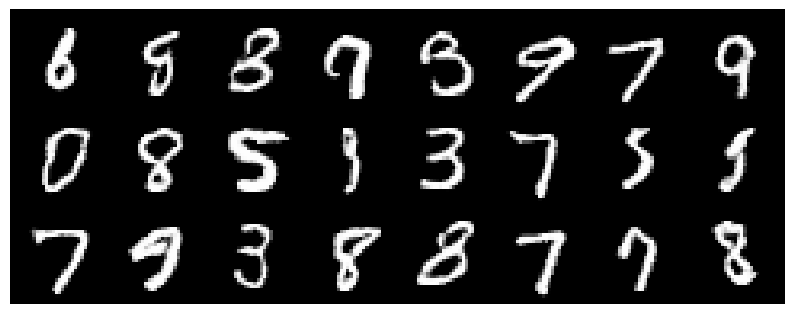

100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.55it/s, loss_D=0.933, loss_G=1.38]


Epoch [74/150] - LR G: 0.0000524, LR D: 0.0000524
Epoch [74/150] - Average D loss: 0.7152, Average G loss: 1.8064


100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.44it/s, loss_D=0.866, loss_G=1.49]


Epoch [75/150] - LR G: 0.0000524, LR D: 0.0000524
Epoch [75/150] - Average D loss: 0.7115, Average G loss: 1.8250


100%|████████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.54it/s, loss_D=0.644, loss_G=1.5]


Epoch [76/150] - LR G: 0.0000524, LR D: 0.0000524
Epoch [76/150] - Average D loss: 0.7134, Average G loss: 1.8196


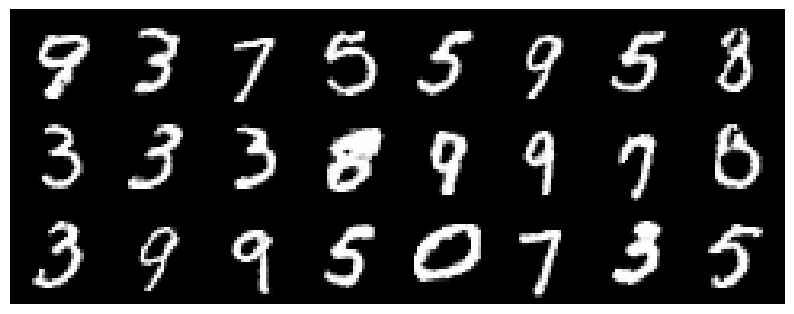

100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.53it/s, loss_D=0.801, loss_G=1.67]


Epoch [77/150] - LR G: 0.0000524, LR D: 0.0000524
Epoch [77/150] - Average D loss: 0.7138, Average G loss: 1.8122


100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.44it/s, loss_D=0.687, loss_G=1.97]


Epoch [78/150] - LR G: 0.0000524, LR D: 0.0000524
Epoch [78/150] - Average D loss: 0.7055, Average G loss: 1.8352


100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.58it/s, loss_D=0.546, loss_G=2.43]


Epoch [79/150] - LR G: 0.0000524, LR D: 0.0000524
Epoch [79/150] - Average D loss: 0.6989, Average G loss: 1.8509


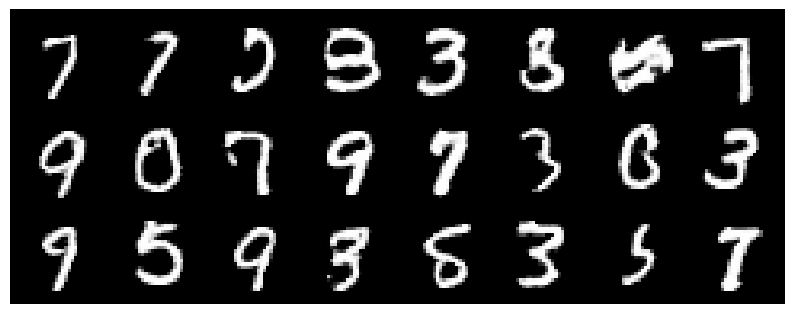

100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.49it/s, loss_D=0.626, loss_G=1.99]


Epoch [80/150] - LR G: 0.0000419, LR D: 0.0000419
Epoch [80/150] - Average D loss: 0.7006, Average G loss: 1.8429


100%|████████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.52it/s, loss_D=0.62, loss_G=2.22]


Epoch [81/150] - LR G: 0.0000419, LR D: 0.0000419
Epoch [81/150] - Average D loss: 0.7012, Average G loss: 1.8379


100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.50it/s, loss_D=0.466, loss_G=1.86]


Epoch [82/150] - LR G: 0.0000419, LR D: 0.0000419
Epoch [82/150] - Average D loss: 0.6997, Average G loss: 1.8396


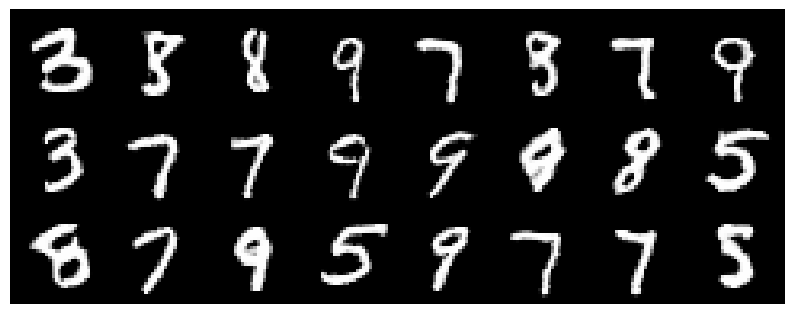

100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.48it/s, loss_D=0.774, loss_G=2.06]


Epoch [83/150] - LR G: 0.0000419, LR D: 0.0000419
Epoch [83/150] - Average D loss: 0.7074, Average G loss: 1.8197


100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.51it/s, loss_D=0.762, loss_G=2.05]


Epoch [84/150] - LR G: 0.0000419, LR D: 0.0000419
Epoch [84/150] - Average D loss: 0.7056, Average G loss: 1.8266


100%|████████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.52it/s, loss_D=0.69, loss_G=1.99]


Epoch [85/150] - LR G: 0.0000419, LR D: 0.0000419
Epoch [85/150] - Average D loss: 0.6985, Average G loss: 1.8420


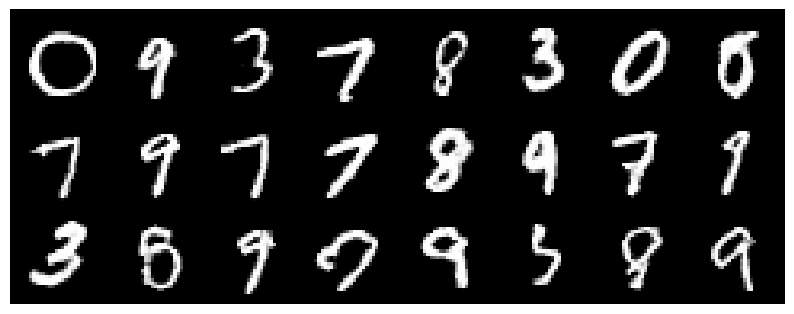

100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.55it/s, loss_D=0.774, loss_G=1.83]


Epoch [86/150] - LR G: 0.0000419, LR D: 0.0000419
Epoch [86/150] - Average D loss: 0.7036, Average G loss: 1.8420


100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.48it/s, loss_D=0.703, loss_G=2.16]


Epoch [87/150] - LR G: 0.0000419, LR D: 0.0000419
Epoch [87/150] - Average D loss: 0.6989, Average G loss: 1.8513


100%|███████████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.56it/s, loss_D=0.63, loss_G=2]


Epoch [88/150] - LR G: 0.0000419, LR D: 0.0000419
Epoch [88/150] - Average D loss: 0.6953, Average G loss: 1.8536


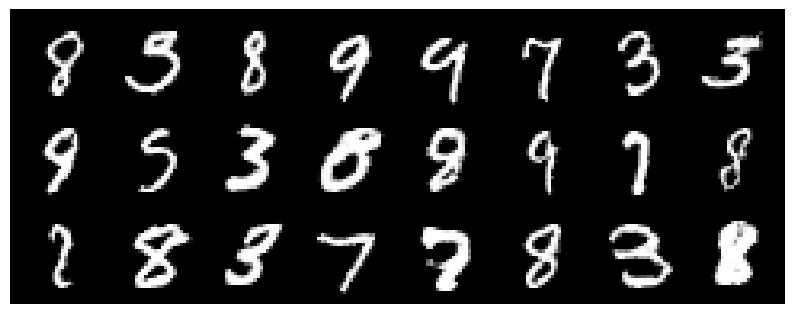

100%|████████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.53it/s, loss_D=0.61, loss_G=1.92]


Epoch [89/150] - LR G: 0.0000419, LR D: 0.0000419
Epoch [89/150] - Average D loss: 0.6997, Average G loss: 1.8440


100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.56it/s, loss_D=0.864, loss_G=1.81]


Epoch [90/150] - LR G: 0.0000419, LR D: 0.0000419
Epoch [90/150] - Average D loss: 0.6895, Average G loss: 1.8607


100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.49it/s, loss_D=0.697, loss_G=2.21]


Epoch [91/150] - LR G: 0.0000419, LR D: 0.0000419
Epoch [91/150] - Average D loss: 0.6939, Average G loss: 1.8610


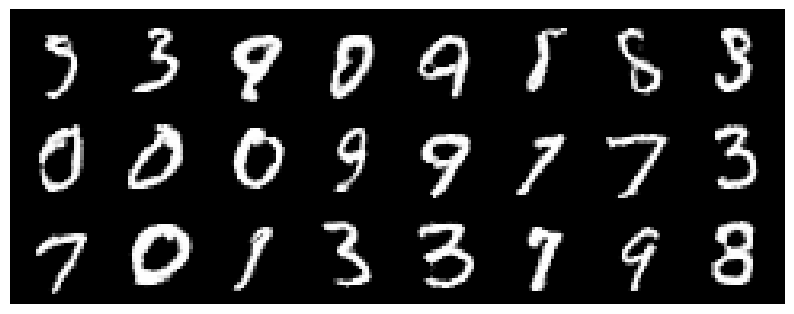

100%|███████████████████████████████████████████████████| 1464/1464 [01:01<00:00, 23.65it/s, loss_D=0.705, loss_G=1.36]


Epoch [92/150] - LR G: 0.0000419, LR D: 0.0000419
Epoch [92/150] - Average D loss: 0.6856, Average G loss: 1.8762


100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.54it/s, loss_D=0.732, loss_G=1.79]


Epoch [93/150] - LR G: 0.0000419, LR D: 0.0000419
Epoch [93/150] - Average D loss: 0.6861, Average G loss: 1.8721


100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.53it/s, loss_D=0.736, loss_G=1.38]


Epoch [94/150] - LR G: 0.0000419, LR D: 0.0000419
Epoch [94/150] - Average D loss: 0.6885, Average G loss: 1.8679


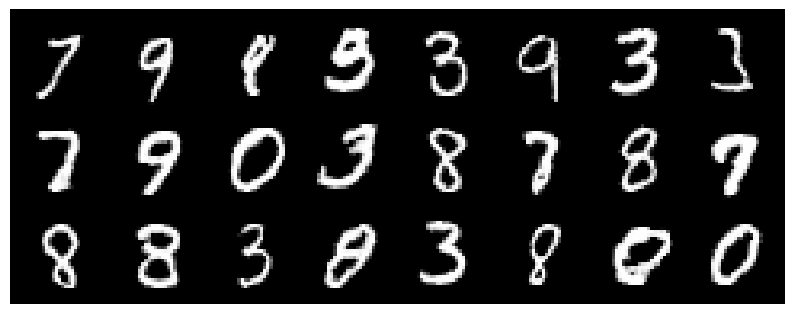

100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.58it/s, loss_D=0.954, loss_G=1.73]


Epoch [95/150] - LR G: 0.0000419, LR D: 0.0000419
Epoch [95/150] - Average D loss: 0.6888, Average G loss: 1.8771


100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.51it/s, loss_D=0.892, loss_G=1.81]


Epoch [96/150] - LR G: 0.0000419, LR D: 0.0000419
Epoch [96/150] - Average D loss: 0.6864, Average G loss: 1.8681


100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.55it/s, loss_D=0.656, loss_G=1.45]


Epoch [97/150] - LR G: 0.0000419, LR D: 0.0000419
Epoch [97/150] - Average D loss: 0.6808, Average G loss: 1.8850


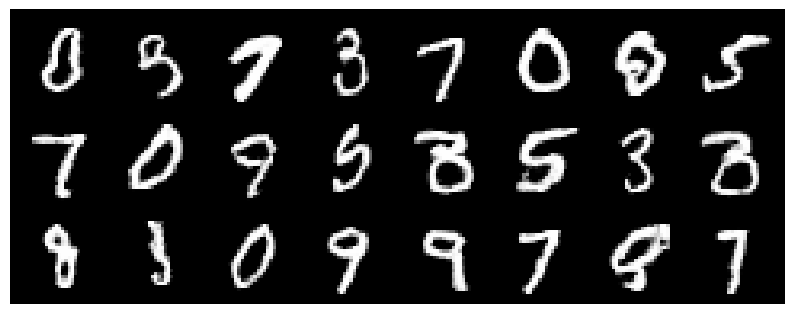

100%|███████████████████████████████████████████████████| 1464/1464 [01:01<00:00, 23.63it/s, loss_D=0.819, loss_G=1.69]


Epoch [98/150] - LR G: 0.0000419, LR D: 0.0000419
Epoch [98/150] - Average D loss: 0.6855, Average G loss: 1.8827


100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.52it/s, loss_D=0.579, loss_G=1.76]


Epoch [99/150] - LR G: 0.0000419, LR D: 0.0000419
Epoch [99/150] - Average D loss: 0.6832, Average G loss: 1.8864


100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.46it/s, loss_D=0.829, loss_G=1.76]


Epoch [100/150] - LR G: 0.0000336, LR D: 0.0000336
Epoch [100/150] - Average D loss: 0.6818, Average G loss: 1.8948


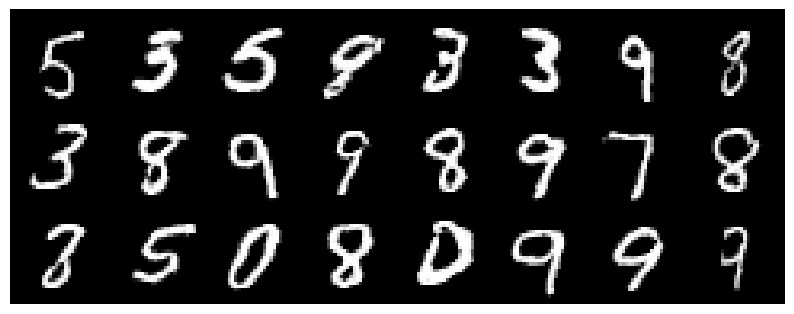

100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.57it/s, loss_D=0.524, loss_G=1.98]


Epoch [101/150] - LR G: 0.0000336, LR D: 0.0000336
Epoch [101/150] - Average D loss: 0.6768, Average G loss: 1.8862


100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.56it/s, loss_D=0.619, loss_G=1.93]


Epoch [102/150] - LR G: 0.0000336, LR D: 0.0000336
Epoch [102/150] - Average D loss: 0.6807, Average G loss: 1.8853


100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.54it/s, loss_D=0.496, loss_G=2.24]


Epoch [103/150] - LR G: 0.0000336, LR D: 0.0000336
Epoch [103/150] - Average D loss: 0.6829, Average G loss: 1.8779


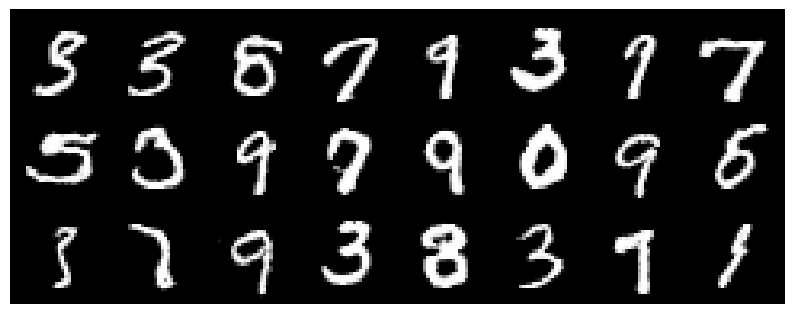

100%|████████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.54it/s, loss_D=0.61, loss_G=1.78]


Epoch [104/150] - LR G: 0.0000336, LR D: 0.0000336
Epoch [104/150] - Average D loss: 0.6799, Average G loss: 1.8849


100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.60it/s, loss_D=0.481, loss_G=1.84]


Epoch [105/150] - LR G: 0.0000336, LR D: 0.0000336
Epoch [105/150] - Average D loss: 0.6777, Average G loss: 1.8930


100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.52it/s, loss_D=0.527, loss_G=1.57]


Epoch [106/150] - LR G: 0.0000336, LR D: 0.0000336
Epoch [106/150] - Average D loss: 0.6770, Average G loss: 1.9028


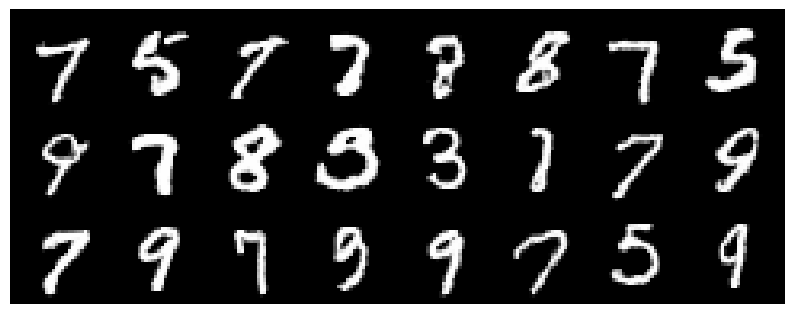

100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.59it/s, loss_D=0.586, loss_G=1.94]


Epoch [107/150] - LR G: 0.0000336, LR D: 0.0000336
Epoch [107/150] - Average D loss: 0.6736, Average G loss: 1.9005


100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.60it/s, loss_D=0.843, loss_G=1.94]


Epoch [108/150] - LR G: 0.0000336, LR D: 0.0000336
Epoch [108/150] - Average D loss: 0.6734, Average G loss: 1.9071


100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.56it/s, loss_D=0.449, loss_G=2.48]


Epoch [109/150] - LR G: 0.0000336, LR D: 0.0000336
Epoch [109/150] - Average D loss: 0.6736, Average G loss: 1.9016


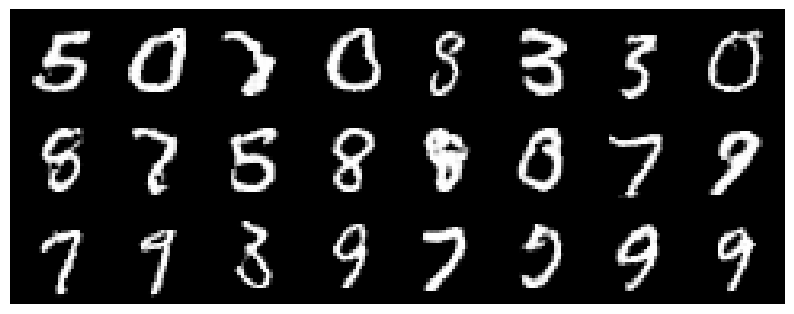

100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.49it/s, loss_D=0.662, loss_G=1.59]


Epoch [110/150] - LR G: 0.0000336, LR D: 0.0000336
Epoch [110/150] - Average D loss: 0.6775, Average G loss: 1.8996


100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.56it/s, loss_D=0.786, loss_G=2.11]


Epoch [111/150] - LR G: 0.0000336, LR D: 0.0000336
Epoch [111/150] - Average D loss: 0.6692, Average G loss: 1.9108


100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.51it/s, loss_D=0.681, loss_G=1.97]


Epoch [112/150] - LR G: 0.0000336, LR D: 0.0000336
Epoch [112/150] - Average D loss: 0.6690, Average G loss: 1.9214


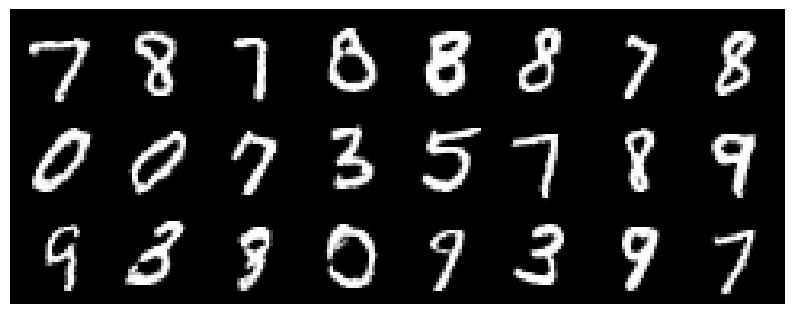

100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.56it/s, loss_D=0.712, loss_G=1.73]


Epoch [113/150] - LR G: 0.0000336, LR D: 0.0000336
Epoch [113/150] - Average D loss: 0.6709, Average G loss: 1.9215


100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.38it/s, loss_D=0.765, loss_G=1.75]


Epoch [114/150] - LR G: 0.0000336, LR D: 0.0000336
Epoch [114/150] - Average D loss: 0.6685, Average G loss: 1.9199


100%|████████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.49it/s, loss_D=0.588, loss_G=1.7]


Epoch [115/150] - LR G: 0.0000336, LR D: 0.0000336
Epoch [115/150] - Average D loss: 0.6691, Average G loss: 1.9289


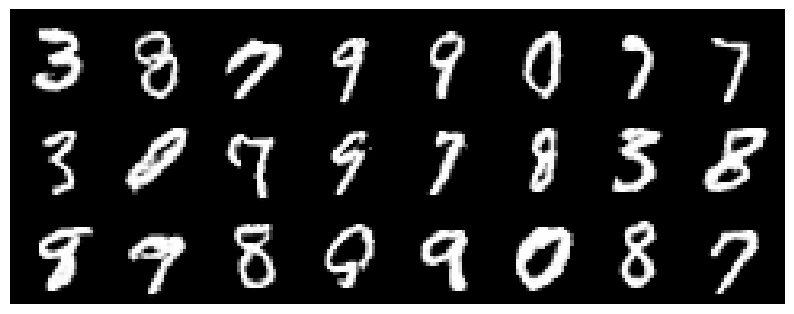

100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.48it/s, loss_D=0.479, loss_G=1.79]


Epoch [116/150] - LR G: 0.0000336, LR D: 0.0000336
Epoch [116/150] - Average D loss: 0.6648, Average G loss: 1.9219


100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.56it/s, loss_D=0.728, loss_G=1.74]


Epoch [117/150] - LR G: 0.0000336, LR D: 0.0000336
Epoch [117/150] - Average D loss: 0.6646, Average G loss: 1.9373


100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.52it/s, loss_D=0.648, loss_G=1.42]


Epoch [118/150] - LR G: 0.0000336, LR D: 0.0000336
Epoch [118/150] - Average D loss: 0.6635, Average G loss: 1.9420


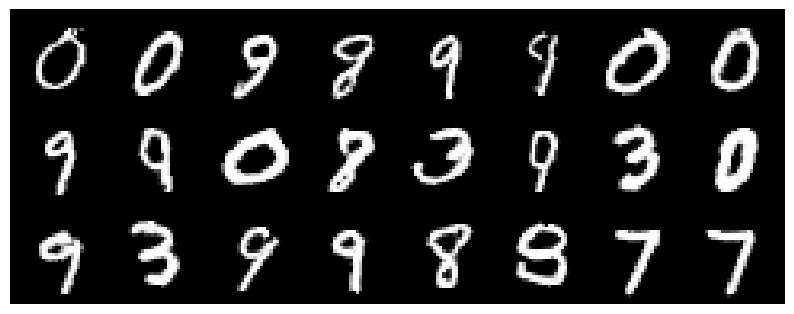

100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.46it/s, loss_D=0.667, loss_G=1.97]


Epoch [119/150] - LR G: 0.0000336, LR D: 0.0000336
Epoch [119/150] - Average D loss: 0.6712, Average G loss: 1.9158


100%|████████████████████████████████████████████████████| 1464/1464 [01:01<00:00, 23.65it/s, loss_D=0.58, loss_G=2.04]


Epoch [120/150] - LR G: 0.0000268, LR D: 0.0000268
Epoch [120/150] - Average D loss: 0.6618, Average G loss: 1.9471


100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.52it/s, loss_D=0.736, loss_G=1.58]


Epoch [121/150] - LR G: 0.0000268, LR D: 0.0000268
Epoch [121/150] - Average D loss: 0.6611, Average G loss: 1.9273


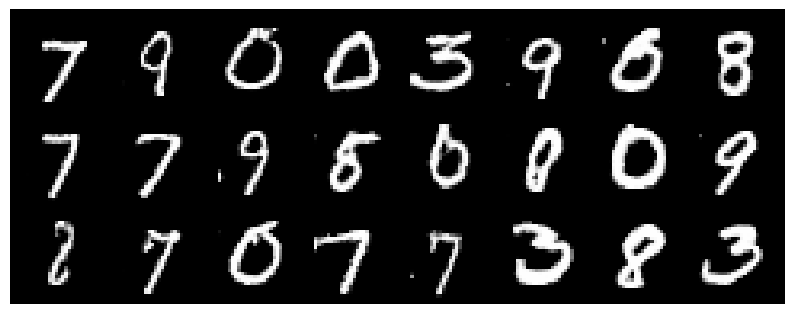

100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.50it/s, loss_D=0.535, loss_G=1.78]


Epoch [122/150] - LR G: 0.0000268, LR D: 0.0000268
Epoch [122/150] - Average D loss: 0.6610, Average G loss: 1.9258


100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.56it/s, loss_D=0.689, loss_G=1.53]


Epoch [123/150] - LR G: 0.0000268, LR D: 0.0000268
Epoch [123/150] - Average D loss: 0.6606, Average G loss: 1.9442


100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.59it/s, loss_D=0.694, loss_G=1.72]


Epoch [124/150] - LR G: 0.0000268, LR D: 0.0000268
Epoch [124/150] - Average D loss: 0.6610, Average G loss: 1.9390


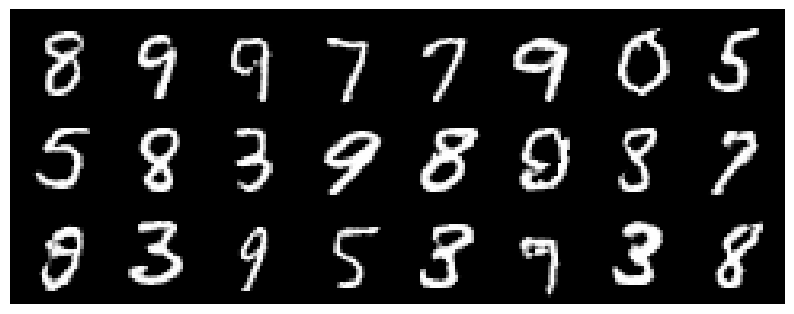

100%|███████████████████████████████████████████████████| 1464/1464 [01:01<00:00, 23.62it/s, loss_D=0.676, loss_G=2.02]


Epoch [125/150] - LR G: 0.0000268, LR D: 0.0000268
Epoch [125/150] - Average D loss: 0.6583, Average G loss: 1.9469


100%|████████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.57it/s, loss_D=0.83, loss_G=1.58]


Epoch [126/150] - LR G: 0.0000268, LR D: 0.0000268
Epoch [126/150] - Average D loss: 0.6584, Average G loss: 1.9422


100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.53it/s, loss_D=0.576, loss_G=1.95]


Epoch [127/150] - LR G: 0.0000268, LR D: 0.0000268
Epoch [127/150] - Average D loss: 0.6581, Average G loss: 1.9474


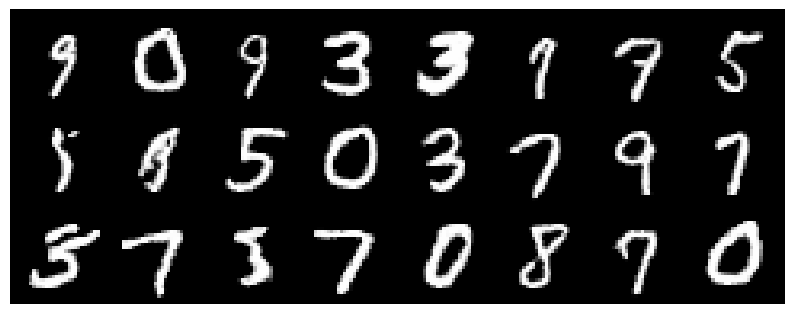

100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.54it/s, loss_D=0.706, loss_G=1.97]


Epoch [128/150] - LR G: 0.0000268, LR D: 0.0000268
Epoch [128/150] - Average D loss: 0.6564, Average G loss: 1.9525


100%|███████████████████████████████████████████████████| 1464/1464 [01:01<00:00, 23.63it/s, loss_D=0.539, loss_G=2.05]


Epoch [129/150] - LR G: 0.0000268, LR D: 0.0000268
Epoch [129/150] - Average D loss: 0.6562, Average G loss: 1.9417


100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.59it/s, loss_D=0.699, loss_G=2.19]


Epoch [130/150] - LR G: 0.0000268, LR D: 0.0000268
Epoch [130/150] - Average D loss: 0.6529, Average G loss: 1.9570


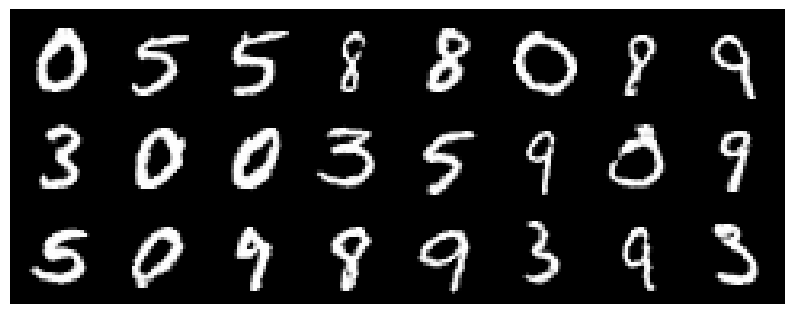

100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.55it/s, loss_D=0.676, loss_G=1.81]


Epoch [131/150] - LR G: 0.0000268, LR D: 0.0000268
Epoch [131/150] - Average D loss: 0.6515, Average G loss: 1.9542


100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.55it/s, loss_D=0.664, loss_G=1.54]


Epoch [132/150] - LR G: 0.0000268, LR D: 0.0000268
Epoch [132/150] - Average D loss: 0.6564, Average G loss: 1.9513


100%|████████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.51it/s, loss_D=0.64, loss_G=1.99]


Epoch [133/150] - LR G: 0.0000268, LR D: 0.0000268
Epoch [133/150] - Average D loss: 0.6491, Average G loss: 1.9754


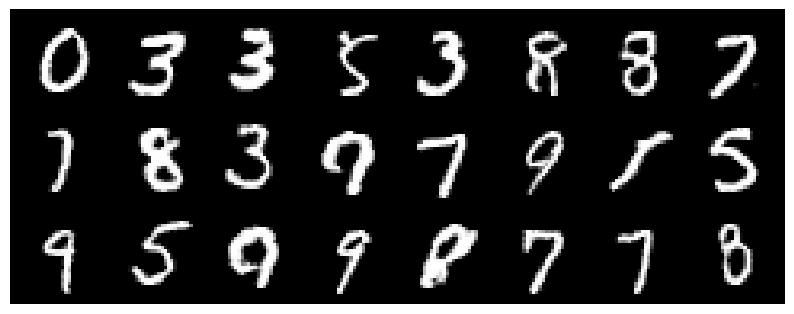

100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.55it/s, loss_D=0.489, loss_G=2.21]


Epoch [134/150] - LR G: 0.0000268, LR D: 0.0000268
Epoch [134/150] - Average D loss: 0.6518, Average G loss: 1.9443


100%|█████████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.61it/s, loss_D=0.91, loss_G=1.7]


Epoch [135/150] - LR G: 0.0000268, LR D: 0.0000268
Epoch [135/150] - Average D loss: 0.6495, Average G loss: 1.9656


100%|████████████████████████████████████████████████████| 1464/1464 [01:01<00:00, 23.64it/s, loss_D=0.351, loss_G=2.3]


Epoch [136/150] - LR G: 0.0000268, LR D: 0.0000268
Epoch [136/150] - Average D loss: 0.6481, Average G loss: 1.9719


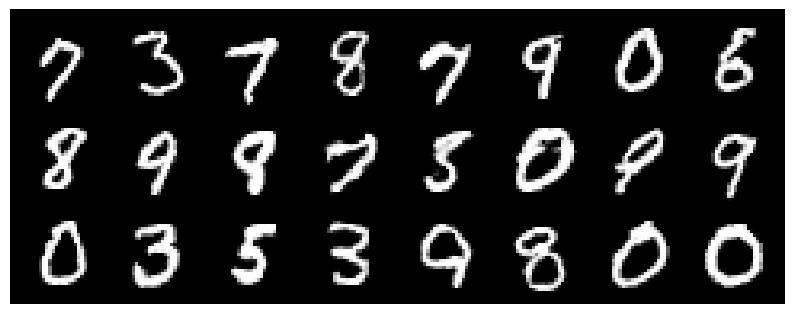

100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.38it/s, loss_D=0.428, loss_G=2.22]


Epoch [137/150] - LR G: 0.0000268, LR D: 0.0000268
Epoch [137/150] - Average D loss: 0.6468, Average G loss: 1.9788


100%|████████████████████████████████████████████████████| 1464/1464 [01:01<00:00, 23.63it/s, loss_D=0.703, loss_G=2.1]


Epoch [138/150] - LR G: 0.0000268, LR D: 0.0000268
Epoch [138/150] - Average D loss: 0.6462, Average G loss: 1.9740


100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.54it/s, loss_D=0.702, loss_G=1.61]


Epoch [139/150] - LR G: 0.0000268, LR D: 0.0000268
Epoch [139/150] - Average D loss: 0.6435, Average G loss: 1.9749


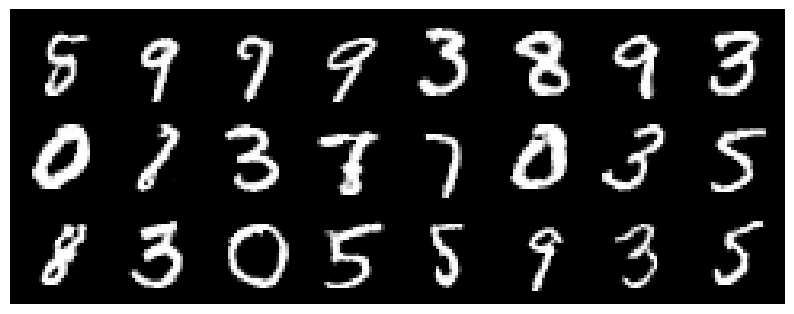

100%|███████████████████████████████████████████████████| 1464/1464 [01:01<00:00, 23.62it/s, loss_D=0.494, loss_G=2.12]


Epoch [140/150] - LR G: 0.0000215, LR D: 0.0000215
Epoch [140/150] - Average D loss: 0.6465, Average G loss: 1.9717


100%|██████████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.58it/s, loss_D=0.586, loss_G=2]


Epoch [141/150] - LR G: 0.0000215, LR D: 0.0000215
Epoch [141/150] - Average D loss: 0.6435, Average G loss: 1.9717


100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.57it/s, loss_D=0.731, loss_G=1.97]


Epoch [142/150] - LR G: 0.0000215, LR D: 0.0000215
Epoch [142/150] - Average D loss: 0.6490, Average G loss: 1.9687


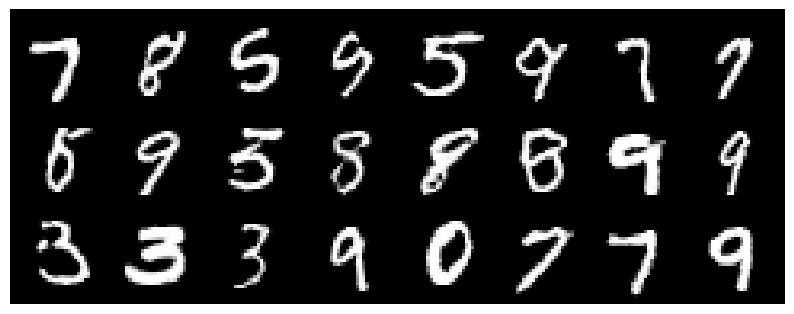

100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.54it/s, loss_D=0.894, loss_G=2.27]


Epoch [143/150] - LR G: 0.0000215, LR D: 0.0000215
Epoch [143/150] - Average D loss: 0.6354, Average G loss: 1.9755


100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.52it/s, loss_D=0.358, loss_G=2.49]


Epoch [144/150] - LR G: 0.0000215, LR D: 0.0000215
Epoch [144/150] - Average D loss: 0.6478, Average G loss: 1.9715


100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.57it/s, loss_D=0.772, loss_G=1.65]


Epoch [145/150] - LR G: 0.0000215, LR D: 0.0000215
Epoch [145/150] - Average D loss: 0.6427, Average G loss: 1.9845


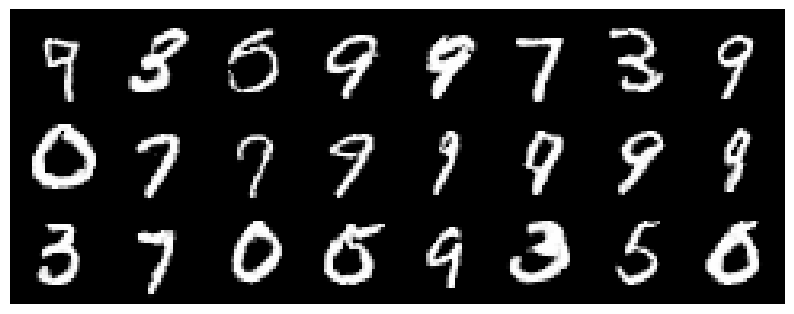

100%|███████████████████████████████████████████████████| 1464/1464 [01:01<00:00, 23.64it/s, loss_D=0.659, loss_G=1.75]


Epoch [146/150] - LR G: 0.0000215, LR D: 0.0000215
Epoch [146/150] - Average D loss: 0.6442, Average G loss: 1.9756


100%|████████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.56it/s, loss_D=0.592, loss_G=1.8]


Epoch [147/150] - LR G: 0.0000215, LR D: 0.0000215
Epoch [147/150] - Average D loss: 0.6357, Average G loss: 1.9946


100%|███████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.56it/s, loss_D=0.595, loss_G=1.96]


Epoch [148/150] - LR G: 0.0000215, LR D: 0.0000215
Epoch [148/150] - Average D loss: 0.6396, Average G loss: 1.9829


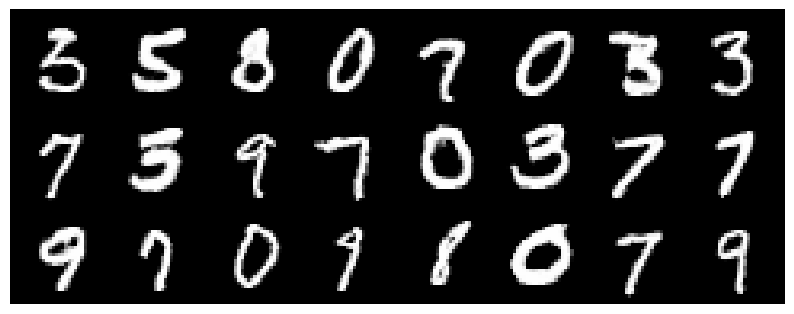

100%|████████████████████████████████████████████████████| 1464/1464 [01:01<00:00, 23.64it/s, loss_D=0.84, loss_G=1.73]


Epoch [149/150] - LR G: 0.0000215, LR D: 0.0000215
Epoch [149/150] - Average D loss: 0.6387, Average G loss: 1.9845


100%|████████████████████████████████████████████████████| 1464/1464 [01:02<00:00, 23.55it/s, loss_D=0.753, loss_G=2.1]

Epoch [150/150] - LR G: 0.0000215, LR D: 0.0000215
Epoch [150/150] - Average D loss: 0.6368, Average G loss: 1.9878


In [14]:
def preprocess_images(images):
    return images.float() * 255.0

# Initialize variables
min_g_loss = float('inf')
epochs = 150
average_d_losses = []  # List to store average discriminator losses per epoch
average_g_losses = []  # List to store average generator losses per epoch

# Assume definitions of loader_discriminator, discriminator, generator, optim_D, and optim_G

for epoch in range(epochs):
    total_d_loss = 0.0
    total_g_loss = 0.0
    count_batches = 0

    loop = tqdm(loader_discriminator, leave=True, total=len(loader_discriminator))
    for real_imgs, _ in loop:
        batch_size = real_imgs.size(0)
        real_imgs = real_imgs.to(device)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        optim_D.zero_grad()
        real_preds = discriminator(real_imgs)
        real_loss = F.binary_cross_entropy(real_preds, real_labels)

        noise = torch.randn(batch_size, noise_dim).to(device)
        fake_imgs = generator(noise)
        fake_preds = discriminator(fake_imgs.detach())
        fake_loss = F.binary_cross_entropy(fake_preds, fake_labels)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optim_D.step()

        optim_G.zero_grad()
        tricked_preds = discriminator(fake_imgs)
        g_loss = F.binary_cross_entropy(tricked_preds, real_labels)
        g_loss.backward()
        optim_G.step()

        total_d_loss += d_loss.item()
        total_g_loss += g_loss.item()
        count_batches += 1

        loop.set_postfix(loss_D=d_loss.item(), loss_G=g_loss.item())

    avg_d_loss = total_d_loss / count_batches
    avg_g_loss = total_g_loss / count_batches

    average_d_losses.append(avg_d_loss)
    average_g_losses.append(avg_g_loss)

    scheduler_G.step()
    scheduler_D.step()

    lr_G = optim_G.param_groups[0]['lr']
    lr_D = optim_D.param_groups[0]['lr']

    # Print current learning rates
    print(f"Epoch [{epoch + 1}/{epochs}] - LR G: {lr_G:.7f}, LR D: {lr_D:.7f}")
    print(f"Epoch [{epoch + 1}/{epochs}] - Average D loss: {avg_d_loss:.4f}, Average G loss: {avg_g_loss:.4f}")

    if epoch % 3 == 0:
        with torch.no_grad():
            test_noise = torch.randn(batch_size, noise_dim).to(device)
            generated_images = generator(test_noise)
            generated_images = preprocess_images(generated_images)

            plt.figure(figsize=(10, 10))
            grid = make_grid(generated_images, nrow=8, normalize=True)
            plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
            plt.axis('off')
            plt.show()

torch.save(generator.state_dict(), 'best_generator1.pth')

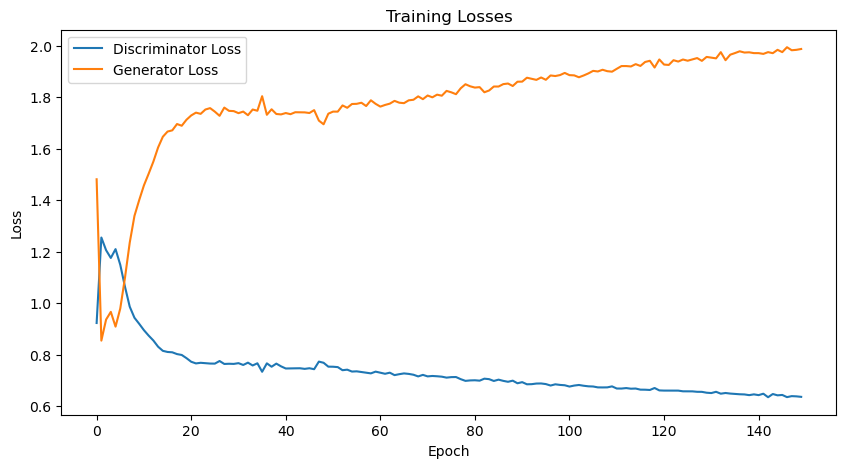

In [15]:
# Plotting the training losses
plt.figure(figsize=(10, 5))
plt.plot(average_d_losses, label='Discriminator Loss')
plt.plot(average_g_losses, label='Generator Loss')
plt.title('Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
def calculate_transposed_conv_output_size(H_in, W_in, K, S, P, O):
    """
    Calculate the output dimensions (height and width) of a transposed convolution layer.

    Parameters:
    H_in (int): Height of the input feature map.
    W_in (int): Width of the input feature map.
    K (int): Kernel size.
    S (int): Stride.
    P (int): Padding applied to the input.
    O (int): Output padding.

    Returns:
    tuple: (H_out, W_out) output height and width.
    """
    H_out = (H_in - 1) * S - 2 * P + K + O
    W_out = (W_in - 1) * S - 2 * P + K + O
    return H_out, W_out

# Example usage with specific parameters
H_in, W_in = 26, 26  # Example input dimensions
K = 3             # Kernel size
S = 1              # Stride
P = 0              # Padding
O = 0              # Output padding

# Calculate output dimensions
output_dims = calculate_transposed_conv_output_size(H_in, W_in, K, S, P, O)
output_dims

(28, 28)

In [17]:
def calculate_conv_output_size(input_size, kernel_size, stride, padding):
    """
    Calculate the output size of a convolutional layer.

    Args:
    input_size (tuple): The height and width of the input image (height, width).
    kernel_size (int): The size of the kernel/filter.
    stride (int): The stride of the convolution operation.
    padding (int): The padding added to the input image.

    Returns:
    tuple: The height and width of the output image (height, width).
    """
    input_height, input_width = input_size

    output_height = (input_height + 2 * padding - kernel_size) // stride + 1
    output_width = (input_width + 2 * padding - kernel_size) // stride + 1

    return (output_height, output_width)

# Example usage:
input_height = 28  # Example input height
input_width = 28   # Example input width
kernel_size = 3
stride = 2
padding = 2

output_size = calculate_conv_output_size((input_height, input_width), kernel_size, stride, padding)
print("Output size:", output_size)

Output size: (15, 15)


In [18]:
# Load the trained generator weights
generator.load_state_dict(torch.load('best_generator1.pth'))
generator.eval()  # Set to evaluation mode

Generator(
  (fc): Linear(in_features=49, out_features=49, bias=True)
  (convT1): ConvTranspose2d(1, 128, kernel_size=(4, 4), stride=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convT2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convT3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convT4): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convT5): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(1, 1))
)

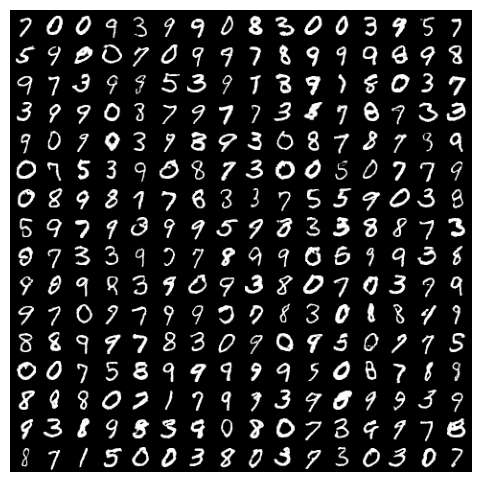

In [19]:
# Generate noise vectors
batch_size = 256  # Number of images to generate
noise = torch.randn(batch_size, noise_dim).to(device)

# Generate images from noise vectors
with torch.no_grad():
    fake_images = generator(noise)

# Assuming images are 28x28 and need to be reshaped
fake_images = fake_images.view(batch_size, 1, 28, 28)  # Reshape images to BxCxHxW format if needed
grid = make_grid(fake_images, nrow=16, normalize=True)  # Create a grid of images

# Visualize images
plt.figure(figsize=(6, 6))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())  # Adjust the channel ordering
plt.axis('off')
plt.show()
